In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils

import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image

from RES_VAE import VAE as VAE


In [2]:
batchSize = 32
imageSize = 64
lr = 1e-4
nepoch = 100
start_epoch = 0
dataset_root = "/data"
save_dir = os.getcwd()
model_name = "VAE_STL10"
load_checkpoint  = True

In [3]:
use_cuda = torch.cuda.is_available()
GPU_indx  = 0
device = torch.device(GPU_indx if use_cuda else "cpu")

In [4]:
def get_data_STL10(transform, batch_size, download = True, root = "/data"):
    print("Loading trainset...")
    trainset = Datasets.STL10(root=root, split='unlabeled', transform=transform, download=download)
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
    
    print("Loading testset...")
    testset = Datasets.STL10(root=root, split='test', download=download, transform=transform)

    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)
    print("Done!")

    return trainloader, testloader

def vae_loss(recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy_with_logits(recon, x)
    KL_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    loss = recon_loss + 0.01 * KL_loss
    return loss

# Feature extractor <br>
Using a pre-tranined VGG-16 we insert an empty layer (after a relu) to capture the feature maps

In [5]:
#create an empty layer that will simply record the feature map passed to it.
class GetFeatures(nn.Module):
    def __init__(self):
        super(GetFeatures, self).__init__()
        self.features = None
    def forward(self, x):
        self.features = x
        return x

#download the pre-trained weights of the VGG-19 and append them to an array of layers .
#we insert a layers_deep layer after a relu layer.
#layers_deep controls how deep we go into the network
def get_feature_extractor(layers_deep = 7):
    C_net = models.vgg19(pretrained=True).to(device)
    C_net = C_net.eval()
    
    layers = []
    for i in range(layers_deep):
        layers.append(C_net.features[i])
        if isinstance(C_net.features[i], nn.ReLU):
            layers.append(GetFeatures())
    return nn.Sequential(*layers)

#this function calculates the L2 loss (MSE) on the feature maps copied by the layers_deep
#between the reconstructed image and the origional
def feature_loss(img, recon_data, feature_extractor):
    img_cat = torch.cat((img, torch.sigmoid(recon_data)), 0)
    out = feature_extractor(img_cat)
    loss = 0
    for i in range(len(feature_extractor)):
        if isinstance(feature_extractor[i], GetFeatures):
            loss += (feature_extractor[i].features[:(img.shape[0])] - feature_extractor[i].features[(img.shape[0]):]).pow(2).mean()
    return loss/(i+1)

In [6]:
#Linear scaling the learning rate down
def lr_Linear(epoch_max, epoch, lr):
    lr_adj = ((epoch_max-epoch)/epoch_max)*lr
    set_lr(lr = lr_adj)

def set_lr(lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
transform = T.Compose([T.Resize(imageSize), T.ToTensor()])

trainloader, testloader = get_data_STL10(transform, batchSize, download = False, root = dataset_root)

Loading trainset...
Loading testset...
Done!


In [8]:
#get a test image batch from the testloader to visualise the reconstruction quality
dataiter = iter(testloader)
test_images = dataiter.next()[0]
test_images.shape

torch.Size([32, 3, 64, 64])

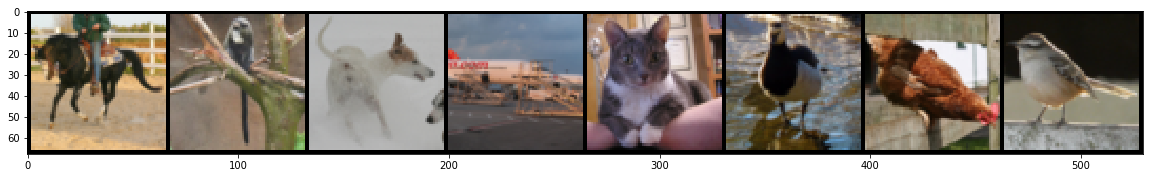

In [9]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8])
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [10]:
#Create VAE network
vae_net = VAE(channel_in = 3).to(device)
#Create feature extractor network
feature_extractor = get_feature_extractor()
# setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=lr, betas=(0.5, 0.999))
#Loss function
BCE_Loss = nn.BCEWithLogitsLoss()
loss_log = []

In [11]:
#Create the save directory if it does note exist
if not os.path.isdir(save_dir + "/Models"):
    os.makedirs(save_dir + "/Models")
if not os.path.isdir(save_dir + "/Results"):
    os.makedirs(save_dir + "/Results")

if load_checkpoint:
    checkpoint = torch.load(save_dir + "/Models/" + model_name + "_" + str(imageSize) + ".pt", map_location = "cpu")
    print("Checkpoint loaded")
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    vae_net.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint["epoch"]
    loss_log = checkpoint["loss_log"]
else:
    #If checkpoint does exist raise an error to prevent accidental overwriting
    if os.path.isfile(save_dir + "/Models/" + model_name + "_" + str(imageSize) + ".pt"):
        raise ValueError("Warning Checkpoint exists")
    else:
        print("Starting from scratch")

Checkpoint loaded


In [ ]:
recon_data, mu, logvar = vae_net(test_images.to(device))

In [ ]:
for epoch in range(start_epoch, nepoch):
    lr_Linear(nepoch, epoch, lr)
    for i, data in enumerate(trainloader, 0):

        recon_data, mu, logvar = vae_net(data[0].to(device))
        
        #VAE loss
        loss = vae_loss(recon_data, data[0].to(device), mu, logvar)
        
        #Perception loss
        loss_feature = feature_loss(data[0].to(device), recon_data, feature_extractor)

        loss += loss_feature
        
        loss_log.append(loss.item())
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

        clear_output(True)
        print('Epoch: [%d/%d], Itteration: [%d/%d] loss: %.4f' 
              % (epoch, nepoch, i, len(trainloader), loss.item()))
        
    with torch.no_grad():
        #For validation we set Train = False which will skip the sampling/reparameterization step
        #and just use mu to decode
        recon_data, _, _ = vae_net(test_images.to(device), Train = False)

        vutils.save_image(torch.cat((torch.sigmoid(recon_data.cpu()), test_images),2),"%s/%s/%s_%d.png" % (save_dir, "Results" , model_name, imageSize))

    #     #Save a checkpoint
        torch.save({
                    'epoch'                         : epoch,
                    'loss_log'                      : loss_log,
                    'model_state_dict'              : vae_net.state_dict(),
                    'optimizer_state_dict'          : optimizer.state_dict()

                     }, save_dir + "/Models/" + model_name + "_" + str(imageSize) + ".pt")  